In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
from scipy.stats import skewnorm, skew, kurtosis, entropy, binned_statistic, anderson
from scipy.signal import savgol_filter
from tqdm import tqdm
import string

result = anderson(your_data, dist='norm')  # Custom dist testing is more manual
print(result.statistic, result.critical_values)

sigmay = np.array([[0, 0, 0, -1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0],
                   [-1, 0, 0, 0]])

def Concurrence(n=4, real=True):
    """Generate a random density matrix of size 4 x 4 and Find its concurrence.
    
    Args:
        n (int): Size of the matrix (default is 4).
        real (bool): If True, generate a real density matrix.
        
    Returns:
        float: Concurrence of the generated density matrix.
    """


    # Generate a random density matrix
    A = np.random.normal(0,1,(4, n)) + (0 if real else 1j * np.random.normal(0,1,(4, n)))
    H = A @ A.conj().T  # Make it Hermitian
    G = H/H.trace()  # Normalize the trace to 1

    #Compute spin-flipped matrix
    G_tilde = sigmay @ G @ sigmay
    R = sqrtm(G) @ sqrtm(G_tilde) 


    # Compute singular values of R
    s = np.sort(np.linalg.svd(R, compute_uv=False))[::-1]  # Sort singular values in descending order

    # Compute concurrence
    C = np.real_if_close(s[0]-np.sum(s[1:]))
    
    # commpute purity of the density matrix
    purity = np.trace(G @ G)

    return C, G, purity

def plot_concurrence_distribution(N,bins,tol=1e-10):
    """Plot the distribution of concurrence values.
    
    Args:
        N (int): Number of random density matrices to generate.
        bins (int): Number of bins for the histogram.

    returns:
        None: Displays a plot of the distribution of concurrence values.
    """

    C_real = np.zeros(N)
    C_imag = np.zeros(N)
    P_real = np.zeros(N)
    P_imag = np.zeros(N)
    C_real_max = []
    C_imag_max = []
    print("Generating random density matrices and computing concurrence...")
    for i in tqdm(range(N), desc="Concurrence Calculation Progress", unit="matrix"):
        C_real[i],_,P_real[i] = Concurrence(real=True)
        C_imag[i],_,P_imag[i] = Concurrence(real=False)

        C_real_max.append((C_real[i]) if C_real[i] > 0 else 0)
        C_imag_max.append((C_imag[i]) if C_imag[i] > 0 else 0)

    def plots():
        
        # Plot the distribution of concurrence values
        print("Plotting the distribution of concurrence values...")
        fig,ax = plt.subplots(2, 2, figsize=(10, 6))
        fig.suptitle(f"Concurrence Distribution for {N} Random Density Matrices", fontsize=16)

        axs = ax.flatten()
        labels = [f"({c})" for c in string.ascii_lowercase]

        ax[0,0].hist(C_real, bins=bins, density=True, alpha=0.5, color='blue', label='Concurrence')
        ax[0,0].set_title("Histogram of Real Density Matrices")
        ax[0,0].set_xlabel("Concurrence")
        ax[0,0].set_ylabel("Density")
        ax[0,0].grid(True)

        ax[0,1].hist(C_imag, bins=bins, density=True, alpha=0.5, color='red', label='Concurrence')
        ax[0,1].set_title("Histogram of Complex Density Matrices")
        ax[0,1].set_xlabel("Concurrence")
        ax[0,1].set_ylabel("Density")
        ax[0,1].grid(True)

        sns.kdeplot(C_real, color='blue', label='Real', ax=ax[1,0])
        sns.kdeplot(C_imag, color='red', label='Complex', ax=ax[1,0])
        ax[1,0].set_title("Probability Curve of Pre-Concurrence")
        ax[1,0].set_xlabel("Concurrence")
        ax[1,0].set_ylabel("Density")
        ax[1,0].grid(True)
        ax[1,0].legend()

        sns.kdeplot(C_real, color='blue', label='Real', ax=ax[1,1])
        sns.kdeplot(C_imag, color='red', label='Complex', ax=ax[1,1])
        ax[1,1].set_title("Probability Curve of Concurrence")
        ax[1,1].set_xlabel("Concurrence")
        ax[1,1].set_ylabel("Density")
        ax[1,1].grid(True)
        ax[1,1].legend()
        ax[1,1].set_xlim(0, 1)
        
        for i, ax_i in enumerate(axs):
            ax_i.text(0.02, 0.95, labels[i], transform=ax_i.transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='left')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
        plt.show()

    def bootstrap_params(data, n_bootstrap=1000):
    alphas = [] 
    locs = [] 
    scales = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        alpha, loc, scale = skewnorm.fit(sample)
        alphas.append(alpha)
        locs.append(loc)
        scales.append(scale)
    return np.std(alphas), np.std(locs), np.std(scales)

    # Example
    std_alpha, std_loc, std_scale = bootstrap_params(your_data)
    print("Uncertainties:", std_alpha, std_loc, std_scale)

    def curve_fit(C_real, C_imag):
        """Fit a skewnormal distribution to the concurrence values and plot the results."""
        print("\nFitting a skewnormal distribution to the concurrence values...")

        params_real = skewnorm.fit(C_real)
        params_imag = skewnorm.fit(C_imag)
        
        alpha_r, loc_r, scale_r = params_real
        alpha, loc, scale = params_imag

        x = np.linspace(min(C_real.min(), C_imag.min()), max(C_real.max(), C_imag.max()), bins)

        pdf_real = skewnorm.pdf(x, *params_real)
        pdf_imag = skewnorm.pdf(x, *params_imag)

        plt.plot(x, pdf_real, 'b--', label=f'Skew-normal fit (Real), alpha={params_real[0]:.2f}')
        plt.plot(x, pdf_imag, 'r--', label=f'Skew-normal fit (Complex), alpha={params_imag[0]:.2f}')
        sns.kdeplot(C_real, color='blue', label='Real', ax=plt.gca())
        sns.kdeplot(C_imag, color='red', label='Imaginary', ax=plt.gca())
        plt.title("Curve Fitted to Concurrence Curve")
        plt.xlabel("Concurrence")
        plt.ylabel("Density")
        plt.grid(True)
        plt.xlim(0,1)
        plt.legend()
        plt.show()

        print(f"Fitted parameters for Real Density Matrix: alpha={alpha_r}, loc={loc_r}, scale={scale_r}")
        print(f"Fitted parameters for Complex Density Matrix: alpha={alpha}, loc={loc}, scale={scale}")

        
        real_result = anderson(params_real, dist='norm')  
        cmpl_result = anderson(params_imag, dist='norm')
        print(real_result.statistic, real_result.critical_values)
        print(cmpl_result.statistic, cmpl_result.critical_values)

        decay_rate_real=(x-loc_r)/(scale_r**2)
        decay_rate_imag=(x-loc)/(scale**2)

        plt.figure(figsize=(8, 6))
        plt.plot(x, decay_rate_real, 'b--', label='Real')
        plt.plot(x, decay_rate_imag, 'r--', label='Complex')
        plt.title("Decay Rate of Concurrence")
        plt.xlabel("Concurrence")
        plt.ylabel("Decay Rate")
        plt.xlim(0,1)
        plt.grid(True)
        plt.legend()
        plt.show()

    

        
    def descriptors(C, name=""):
        """Calculate and print statistics of the concurrence values."""
        print("\nCalculating statistics of the concurrence values...")
        
        C = np.array(C)
        C_positive = C[C > 0]

        print(f"\n--- Statistics for {name} ---")
        print(f"Mean: {np.mean(C):.4f}")
        print(f"Std. Deviation: {np.std(C):.4f}")
        print(f"Skewness: {skew(C):.4f}")
        print(f"Kurtosis: {kurtosis(C):.4f}")
        print(f"Fraction with C > 0: {np.sum(C > 0) / len(C):.4f}")
        
        # Optional: Entropy from histogram
        hist, bins = np.histogram(C, bins=100, density=True)
        hist = hist[hist > 0]  # Avoid log(0)
        print(f"Histogram Entropy: {entropy(hist):.4f}")

    def purity_vs_entanglement(bins=1000):
        bins = np.linspace(0.25, 1, 50)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        

        mean_C_real, _, _ = binned_statistic(P_real, C_real_max, statistic='mean', bins=bins)
        mean_C_imag, _, _ = binned_statistic(P_imag, C_imag_max, statistic='mean', bins=bins)


        plt.plot(bin_centers, mean_C_real, label='Real', color='blue')
        plt.plot(bin_centers, mean_C_imag, label='Complex', color='red')
        plt.xlabel("Purity")
        plt.ylabel("Average Concurrence")
        plt.title("Mean Concurrence vs Purity")
        plt.legend()
        plt.xlim(0.3,0.7)
        plt.grid(True)
        plt.show()

    def Probability(N,tol =tol):
        """Calculate the probability of concurrence > 0 for real and complex density matrices."""
        print("\nCalculating the Fraction of Entangled and Separable states using concurrence values...")
        for i in range()
        prob_real = np.sum(C_real_max >= tol) / N
        prob_imag = np.sum(C_imag_max >= tol) / N
        print(f"Fraction of Entangled states in Real Density Matrices: {prob_real:.4f}")
        print(f"Fraction of Separable states in Real Density Matrices: {1 - prob_real:.4f}")
        print(f"\nFraction of Entangled states in Complex Density Matrices: {prob_imag:.4f}")
        print(f"Fraction of Separable States in Complex Density Matrices: {1 - prob_imag:.4f}")


    def estimate_seperable_fraction(N=N,real=True):
        """Estimate the fraction of separable states in a set of random density matrices.
        
        Args:
            N (int): Number of random density matrices to generate.
            
        Returns:
            float: Estimated fraction of separable states.
        """
        print("\nCalculating the fraction of Entangled and Separable states using PPT test...")
        
        count_separable = 0
        for _ in range(N):
            _,rho,_ = Concurrence(real=real)
            rho_pt = rho.reshape((2,2)+(2,2))
            rho_pt = np.swapaxes(rho_pt, 1, 2).reshape(4,4)
            eigvals = np.linalg.eigvalsh(rho_pt)
            if np.all(eigvals >= -tol):  # small tol like 1e-8
                count_separable += 1
    
        separable_frac = count_separable / N
        entangled_frac = 1 - separable_frac
        if real:
            print("Fraction of Entangled states in real density matrix:",entangled_frac)
            print("Fraction of Separable states in real density matrices: ", separable_frac)
        else:
            print("Fraction of Entangled states in Complex density matrix:",entangled_frac)
            print("Fraction of Separable states in Complex density matrices: ", separable_frac)
            

    def weakly_entangled(C_real, C_imag):
        """Calculate the fraction of weakly entangled states."""
        print("\nCalculating the fraction of weakly entangled states...")

        threshold_low = 1e-8
        threshold_high = 0.01  # You can adjust this to see a wider/narrower window

        # Filter the tiny concurrence values
        C_real_weak = C_real[(C_real >= threshold_low) & (C_real <= threshold_high)]
        C_imag_weak = C_imag[(C_imag >= threshold_low) & (C_imag <= threshold_high)]

        prob_real = len(C_real_weak) / len(C_real)
        prob_imag = len(C_imag_weak) / len(C_imag)

        print(f"Fraction of Weakly Entangled States in Real Density Matrices: {prob_real:.4f}")
        print(f"Fraction of Weakly Entangled States in Complex Density Matrices: {prob_imag:.4f}")


    # Call the functions to plot and calculate statistics
    """
    plots()
    
    curve_fit(C_real,C_imag)
    
    decay_rate(C_real,C_imag)
    
    descriptors(C_real, "Real Density Matrices")
    descriptors(C_imag, "Complex Density Matrices")

    purity_vs_entanglement()
    
    Probability()
    estimate_seperable_fraction(N=N,real=True)
    estimate_seperable_fraction(N=N,real=False)
    weakly_entangled(C_real, C_imag)
    """

    
    
    Probability(N=N, tol = tol)
    estimate_seperable_fraction(N=N, real=True)
    estimate_seperable_fraction(N=N, real=False)
    weakly_entangled(C_real,C_imag)
    purity_vs_entanglement()



N=int(input("Enter the number of random density matrices to generate: "))
bins=int(input("Enter the number of bins for the histogram: "))

plot_concurrence_distribution(N, bins,tol=0.01)
# The code generates a random density matrix of size 4x4, computes its concurrence, and plots the distribution of concurrence values for both real and complex density matrices. The user can specify the number of random density matrices to generate and the number of bins for the histogram.



Generating random density matrices and computing concurrence...


Concurrence Calculation Progress:   0%|          | 0/100 [00:00<?, ?matrix/s]C:\Users\admin\AppData\Local\Temp\ipykernel_11344\2164943240.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  C_imag[i],_,P_imag[i] = Concurrence(real=False)
Concurrence Calculation Progress: 100%|██████████| 100/100 [00:00<00:00, 668.37matrix/s]


Calculating the Fraction of Entangled and Separable states using concurrence values...


TypeError: '>=' not supported between instances of 'list' and 'float'

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def generate_density_matrix(n=4, real=True):
    """Generate a random density matrix of size 4 x 4 and Find its concurrence.
    
    Args:
        n (int): Size of the matrix (default is 4).
        real (bool): If True, generate a real density matrix.
        
    Returns:
        float: Concurrence of the generated density matrix.
    """
    # Generate a random density matrix
    A = np.random.normal(0,1,(4, n)) + (0 if real else 1j * np.random.normal(0,1,(4, n)))
    H = A @ A.conj().T  # Make it Hermitian
    G = H/H.trace()  # Normalize the trace to 1

    return G

def ppt_test(rho):
    """Perform the PPT test on a density matrix.
    
    Args:
        rho (ndarray): Density matrix to test.
        
    Returns:
        bool: True if the state is separable, False if it is entangled.
    """
    # Compute the partial transpose
    rho_pt = rho.reshape((2,2)+(2,2))
    rho_pt = np.swapaxes(rho_pt, 1, 2).reshape(4,4)
    
    # Check if the eigenvalues of the partial transpose are non-negative
    eigenvalues = np.linalg.eigvals(rho_pt)
    
    return np.all(eigenvalues >= -1e-10)  # Allow for numerical errors

def estimate_seperable_fraction(N=1000000,real=True):
    """Estimate the fraction of separable states in a set of random density matrices.
    
    Args:
        N (int): Number of random density matrices to generate.
        
    Returns:
        float: Estimated fraction of separable states.
    """
    count_separable = 0
    for _ in range(N):
        rho = generate_density_matrix(real=real)
        if ppt_test(rho):
            count_separable += 1
            
    return count_separable / N

print("Fraction of separable states in real density matrices: ", estimate_seperable_fraction(N=1000000,real=True))
print("Fraction of separable states in complex density matrices: ", estimate_seperable_fraction(N=1000000,real=False))

Fraction of separable states in real density matrices:  0.206934
Fraction of separable states in complex density matrices:  0.178834


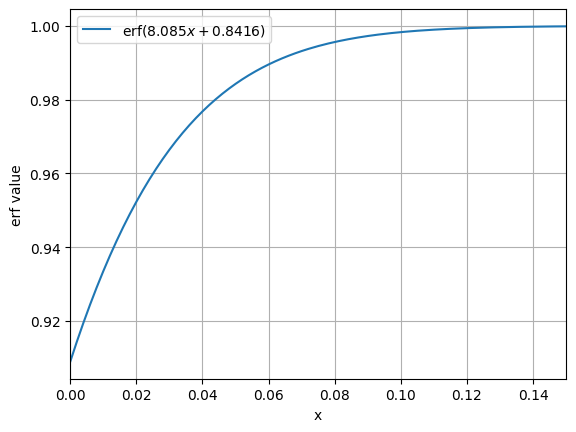

In [102]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt


#when y=0
for i in np.arange(0, 1, 0.01):
    y= erf(8.085 * i + 0.8416)
    if y == 0.9999:
        print("The value of x when erf(8.085x + 0.8416) = 1 is: ", i)
        break

    
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = erf(10.2627 * x + 1.1948)

plt.plot(x, y, label=r'$\mathrm{erf}(8.085x + 0.8416)$')
plt.xlabel('x')
plt.ylabel('erf value')
plt.grid(True)
plt.legend()
plt.xlim(0, 0.15)
plt.show()
